In [3]:
import sys
sys.path.append('..')

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from messis.dataloader import GeospatialDataModule

In [60]:
N_FOLDS = 5

In [9]:
folds = []
for i in range(N_FOLDS):
    data_module = GeospatialDataModule(data_dir='../data/', test_fold=i, batch_size=12, num_workers=1, debug=True, subsets= None)

    data_module.setup()
    folds.append(data_module.test_dataset)

Loading mean/std stats from ../data/chips_fold_stats.yaml
Stats with selected test fold 0: {'mean': [547.4498291015625, 646.3359375, 392.582275390625, 2924.638427734375, 1824.0826416015625, 1107.7821044921875], 'n_bands': 6, 'n_chips': 332, 'n_timesteps': 3, 'std': [465.12786865234375, 402.7886657714844, 362.0007019042969, 1266.59033203125, 648.0706176757812, 542.8402099609375]} over 3 timesteps.
Loading mean/std stats from ../data/chips_fold_stats.yaml
Stats with selected test fold 0: {'mean': [547.4498291015625, 646.3359375, 392.582275390625, 2924.638427734375, 1824.0826416015625, 1107.7821044921875], 'n_bands': 6, 'n_chips': 332, 'n_timesteps': 3, 'std': [465.12786865234375, 402.7886657714844, 362.0007019042969, 1266.59033203125, 648.0706176757812, 542.8402099609375]} over 3 timesteps.
Loading mean/std stats from ../data/chips_fold_stats.yaml
Stats with selected test fold 0: {'mean': [547.4498291015625, 646.3359375, 392.582275390625, 2924.638427734375, 1824.0826416015625, 1107.78210

In [61]:
pixels_by_tier_category_fold = [] # list for each fold: dict with tier as key: dict with category as key: pixel count as value
for i in range(N_FOLDS):
    print(f"Processing fold {i}")
    pixels_by_tier_category = {
        "tier1": {},
        "tier2": {},
        "tier3": {}
    }
    for batch in tqdm(folds[i]):
        targets = batch[1][0]
        for j, tier in enumerate(pixels_by_tier_category.keys()):
            # get the unique values and their counts
            unique, counts = targets[j].unique(return_counts=True)
            # create a dictionary with the unique values and their counts
            for clazz, count in zip(unique, counts):
                if clazz.item() in pixels_by_tier_category[tier]:
                    pixels_by_tier_category[tier][clazz.item()] += count.item()
                else:
                    pixels_by_tier_category[tier][clazz.item()] = count.item()
            #unique_counts = {int(clazz): int(count) for clazz, count in zip(unique, counts)}
            #print(unique_counts)
            
            # add the counts to the corresponding tier
    pixels_by_tier_category_fold.append(pixels_by_tier_category)

Processing fold 0


100%|██████████| 71/71 [00:01<00:00, 37.64it/s]


Processing fold 1


100%|██████████| 81/81 [00:02<00:00, 37.06it/s]


Processing fold 2


100%|██████████| 88/88 [00:02<00:00, 37.64it/s]


Processing fold 3


100%|██████████| 85/85 [00:02<00:00, 37.17it/s]


Processing fold 4


100%|██████████| 78/78 [00:02<00:00, 37.42it/s]


In [55]:
print(f"len(pixels_by_tier_category_fold): {len(pixels_by_tier_category_fold)}")
print(f"len(pixels_by_tier_category_fold[0]): {len(pixels_by_tier_category_fold[0])}")
print(f"len(pixels_by_tier_category_fold[0]['tier1']): {len(pixels_by_tier_category_fold[0]['tier1'])}")
print(f"pixels_by_tier_category_fold[0]['tier1']: {pixels_by_tier_category_fold[0]['tier1']}")

len(pixels_by_tier_category_fold): 5
len(pixels_by_tier_category_fold[0]): 3
len(pixels_by_tier_category_fold[0]['tier1']): 5
pixels_by_tier_category_fold[0]['tier1']: {0: 2436257, 1: 513042, 2: 581132, 4: 12989, 3: 19076}


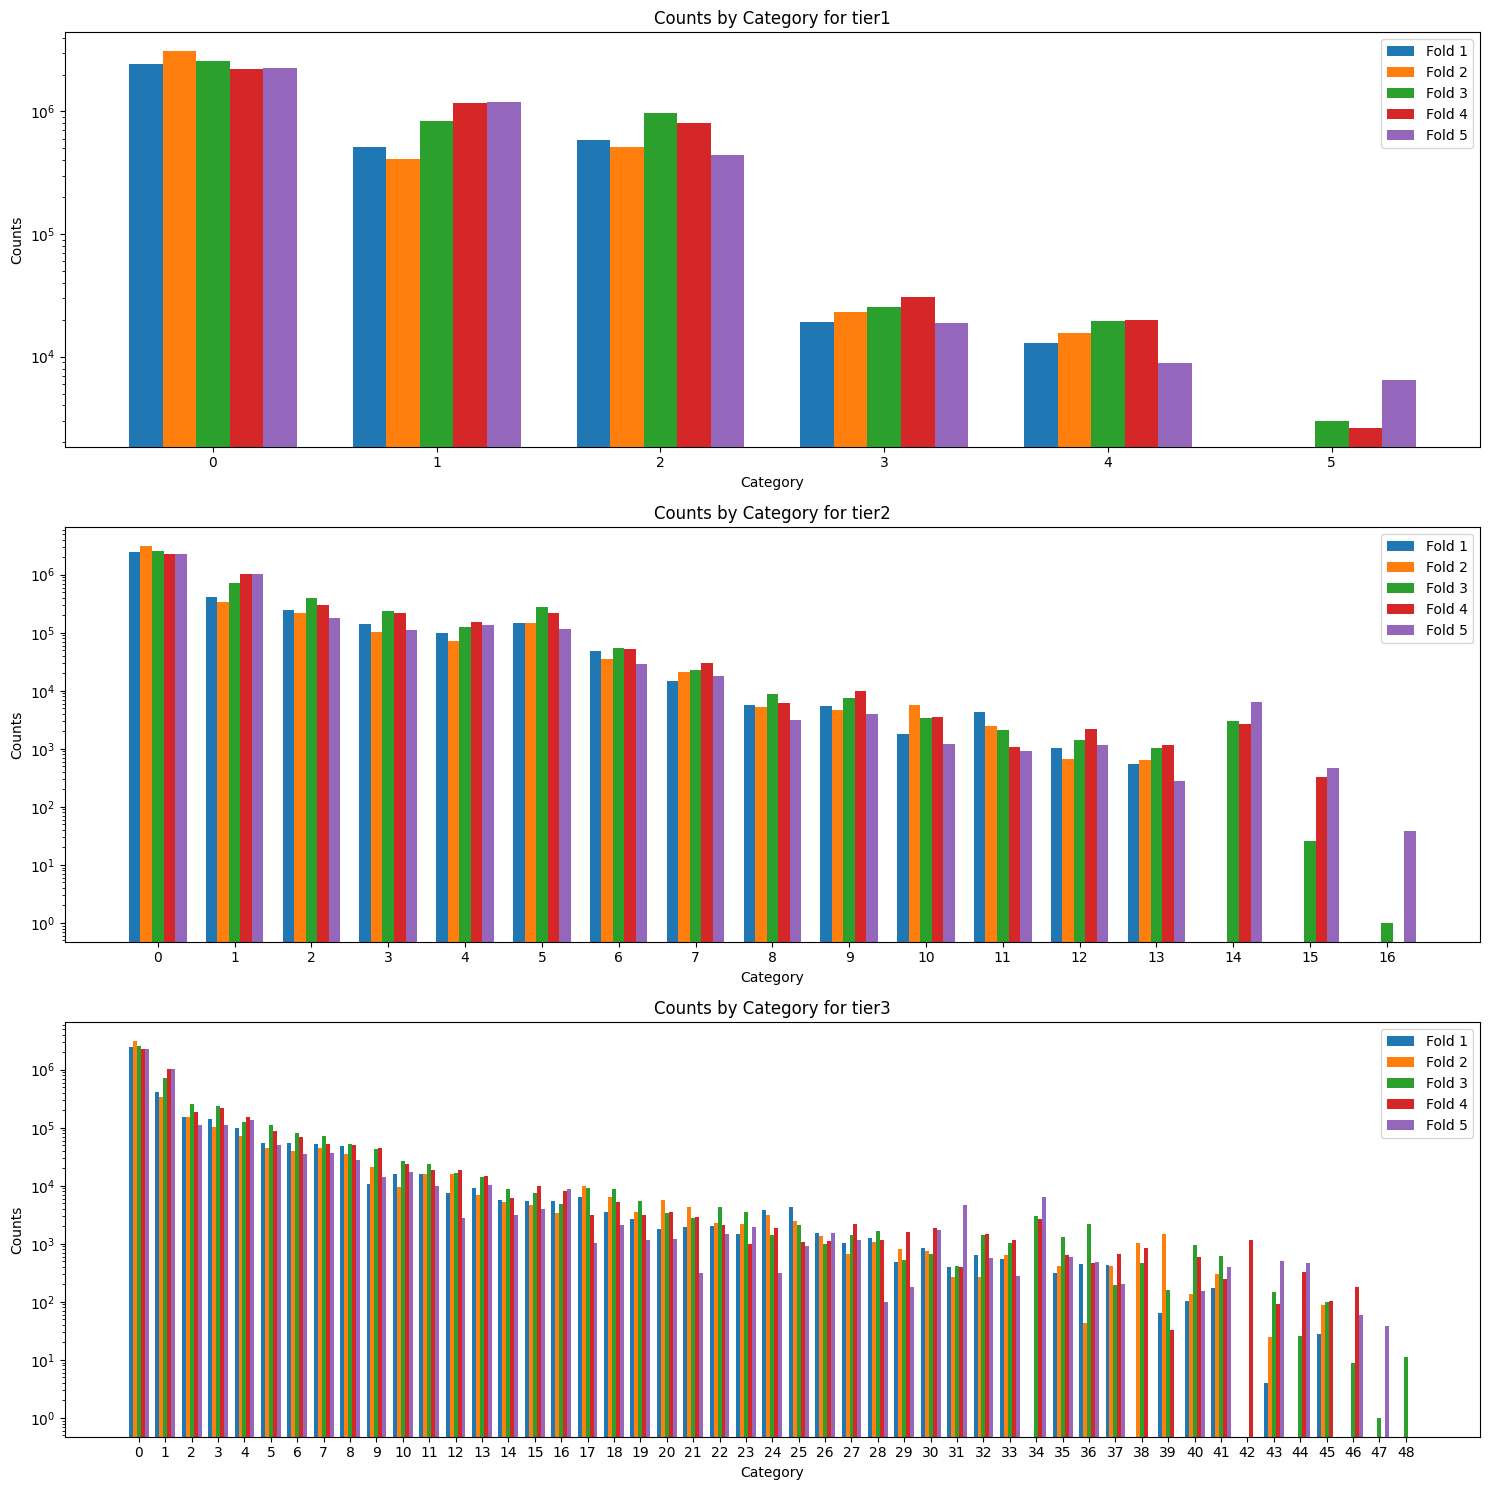

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharex=False)
fig.subplots_adjust(hspace=0.4)

for ax, tier in zip(axes, ["tier1", "tier2", "tier3"]):
    categories = sorted(set().union(*[pixels_by_tier_category_fold[i][tier].keys() for i in range(N_FOLDS)]))
    index = np.arange(len(categories))
    bar_width = 0.15
    for fold in range(N_FOLDS):
        counts = [pixels_by_tier_category_fold[fold][tier].get(cat, 0) for cat in categories]
        ax.bar(index + fold * bar_width, counts, bar_width, label=f'Fold {fold+1}')
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'Counts by Category for {tier}')
    ax.set_xticks(index + bar_width * (N_FOLDS - 1) / 2)
    ax.set_xticklabels(categories)
    ax.legend()

plt.tight_layout()
plt.show()